In [ ]:
# Imports
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import string
import timeit
import torch
from torch import nn
import torch.functional as F
import torch.nn.functional as F
import re
import os
import sys
import warnings
import copy

# To store in and import files from google drive

# from google.colab import drive
# drive.mount('/content/drive2/')
# data_file_location = "/content/drive2/MyDrive/nn_dataset/final/"
# os.chdir(data_file_location)

# end of google drive mount related code

print(f'Current Directory: {os.getcwd()}')

# arr = os.listdir()
# print(', '.join(arr))

from nn_utils import *
import nn_common as nnc

warnings.filterwarnings('ignore')

Mounted at /content/drive2/
Current Directory: /content/drive2/.shortcut-targets-by-id/1-aAopK3Hh5Cd6pFxyYKskeHYiZlx_nLT/nn_dataset/final


In [ ]:
random_state = 60065
seed_all(random_state)

Preprocessing started
Preprocessing finished.
Preprocessing Took 0.9919437610005843 Seconds


count    4665.000000
mean       17.702465
std         9.683710
min         0.000000
25%        10.000000
50%        15.000000
75%        25.000000
max        69.000000
Name: preprocessed_sen_len, dtype: float64


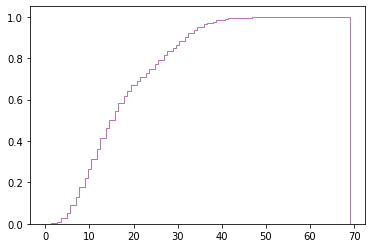


Vocabularies length: 18171


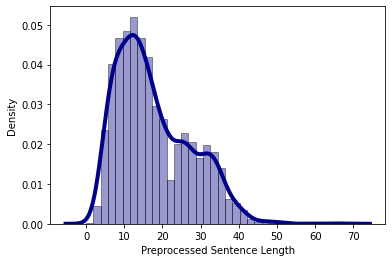

In [ ]:
data_path = "data/hindi_hatespeech.tsv"
stopwords_path = "data/stopwords-hi.txt"
hindi_dc = DataContext()
hindi_dc.load_and_preprocess_data(data_path, stopwords_path)
hindi_dc.create_target(label_colum_name = "task_1", positive_value = "HOF")
hindi_dc.build_vocab()
hindi_dc.convert_word_to_index()

In [ ]:
print(hindi_dc.V[:5])
hindi_dc.dataf.head()

['___PAD___', '___UNK___', 'वैसेही', 'जरूरी', 'sabha']


,text_id,text,task_1,task_2,task_3,preprocessed_sen_len,target
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE,9,0
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT,11,1
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN,34,1
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE,14,0
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE,11,0


# Hindi Sentiment Analysis Using Transformer Encoder and CNN

In this model, we will not use the Embedding matrix from Task 1 and Task 2 as those embedding matrices were not sentence context aware. We know that an embedding matrix's job is to only capture some feature of the words, but the Word2Vec model we used in Task 1 and 2 contains only two linear layers without any non-linear activation such as relu. On the contrary, in the TransformerCNN model, the embedding layers sits behind a really complex Transormer encoder which tries to learn the meaning of words within a sentence followed by a few convolution, pooling and fully connceted layers. So during the backpropagation, not only the intermediate layers learn, as the entire graph is connected, the embedding layer also gets benefited, thus capturing the features more accurately.

In [ ]:
hindi_transformer_params = {
    "padding_idx" : 0,
    "sent_len" : 32,
    "batch_size" : 1,
    "vocab_size": hindi_dc.ONE_HOT_VECTOR_SIZE,
    "embedding_size": 300,
    "num_of_head": 2,
    "num_of_hidden": 50,
    "patience" : 3,
    "dataset_name" : "hindi",
    "weight_decay" : 1e-6,
    "epochs" : 100,
    "learning_rate" : 0.0001,
    "milestones" : [3, 9],
    "gamma" : 0.1,
    "num_of_layers": 2,
    "num_of_classes": 1,
    "dropout": 0.15,
    "conv_params": [
        [1, 32, (1, 21), 1, 0],
        [32, 64, (1, 25), 1, 0],
        [64, 128, (1, 58), 1, 0]
    ]
}

Define the model, training context, optimizer and criterion

In [ ]:
seed_all(60065)
hindi_transformer_cnn = TransformerCNN(hindi_transformer_params)
hindi_transformer_cnn_tc = TrainingContext(hindi_transformer_params)

hindi_transformer_cnn_tc.criterion = nn.BCELoss()

seed_all(60065)
hindi_transformer_cnn_tc.optimizer = torch.optim.Adam(
    hindi_transformer_cnn.parameters(),
    lr = hindi_transformer_params["learning_rate"],
    weight_decay = hindi_transformer_params["weight_decay"])

hindi_transformer_cnn_tc.scheduler = torch.optim.lr_scheduler.MultiStepLR(
    hindi_transformer_cnn_tc.optimizer,
    milestones = hindi_transformer_params["milestones"],
    gamma = hindi_transformer_params["gamma"])

Output shape after conv1: (16, 140)
Output shape after conv2: (8, 58)
Output shape after conv3: (8, 1)
No GPU :(


In [ ]:
print(hindi_transformer_cnn)

TransformerCNN(
  (positional_embedding): PositionalEmbedding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=50, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=50, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (dropout2): Dropout(p=0.15, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_f

Prepare dataloader, and train

Preparing data loader
Size of Training Set :3732, Validation Set: 467, and Test Set: 466
Data loader is ready.
Processed 4665 sentences.
Preparing Data Loader Took 0.04 Seconds


Training started
...................
At epoch 0:
		Learning Rate: .0001
		Avg. training loss: 0.69		Avg. training accuracy: 52.01
		Avg. validation loss: 0.71		Avg. validation accuracy: 49.04
		Validation loss decreased (inf --> 0.708202).  Saving model ...
...................
At epoch 1:
		Learning Rate: .0001
		Avg. training loss: 0.64		Avg. training accuracy: 62.35
		Avg. validation loss: 0.55		Avg. validation accuracy: 74.09
		Validation loss decreased (0.708202 --> 0.547661).  Saving model ...
...................
At epoch 2:
		Learning Rate: .0001
		Avg. training loss: 0.50		Avg. training accuracy: 75.67
		Avg. validation loss: 0.49		Avg. validation accuracy: 80.09
		Validation loss decreased (0.547661 --> 0.490404).  Saving model ...
...................
At epoch 3:
		Learning Rate: .00001
		Avg. training

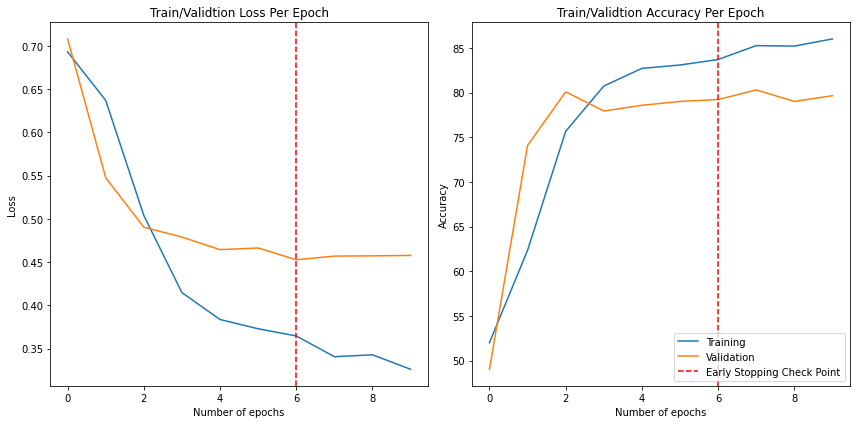


Training Session Info Stored


In [ ]:
seed_all(random_state = 60065)
hindi_transformer_cnn_tc.prepare_dataloaders(
    data_context = hindi_dc)
hindi_transformer_cnn_tc.train(model = hindi_transformer_cnn)

Test

In [ ]:
hindi_transformer_cnn_tc.test(hindi_transformer_cnn)

Test Accuracy: 81.97 %


# Train a completely new model with Bangla Dataset (Sampled)

Here again, we are training a new Embedding matrix instead of using the old one

Preprocessing started
Preprocessing finished.
Preprocessing Took 0.8900762650000615 Seconds


count    4725.000000
mean       10.202540
std        13.961838
min         0.000000
25%         4.000000
50%         7.000000
75%        12.000000
max       260.000000
Name: preprocessed_sen_len, dtype: float64


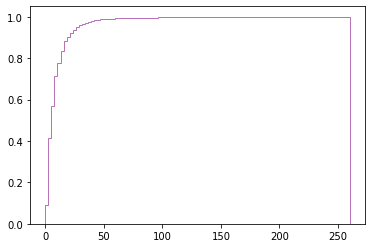


Vocabularies length: 14583


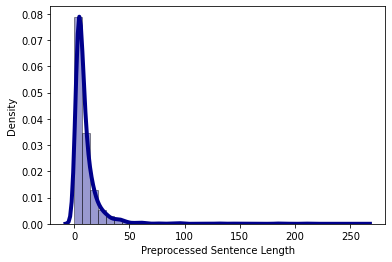

In [ ]:
data_path = "data/bengali_hatespeech_sampled.tsv"
stopwords_path = "data/stopwords-bn.txt"
bangla_dc = DataContext()
bangla_dc.load_and_preprocess_data(data_path, stopwords_path)
bangla_dc.create_target(label_colum_name = "hate", positive_value = 1)
bangla_dc.build_vocab()
bangla_dc.convert_word_to_index()

In [ ]:
bangla_transformer_params = {
    "padding_idx" : 0,
    "sent_len" : 32,
    "batch_size" : 1,
    "vocab_size": bangla_dc.ONE_HOT_VECTOR_SIZE,
    "embedding_size": 300,
    "num_of_head": 2,
    "num_of_hidden": 50,
    "patience" : 3,
    "dataset_name" : "bangla",
    "weight_decay" : 1e-6,
    "epochs" : 100,
    "learning_rate" : 0.0001,
    "milestones" : [3, 9],
    "gamma" : 0.1,
    "num_of_layers": 2,
    "num_of_classes": 1,
    "dropout": 0.15,
    "conv_params": [
        [1, 32, (1, 21), 1, 0],
        [32, 64, (1, 25), 1, 0],
        [64, 128, (1, 58), 1, 0]
    ]
}

In [ ]:
seed_all(60065)
bangla_transformer_cnn = TransformerCNN(bangla_transformer_params)
bangla_transformer_cnn_tc = TrainingContext(bangla_transformer_params)

bangla_transformer_cnn_tc.criterion = nn.BCELoss()

seed_all(60065)
bangla_transformer_cnn_tc.optimizer = torch.optim.Adam(
    bangla_transformer_cnn.parameters(),
    lr = bangla_transformer_params["learning_rate"],
    weight_decay = bangla_transformer_params["weight_decay"])

bangla_transformer_cnn_tc.scheduler = torch.optim.lr_scheduler.MultiStepLR(
    bangla_transformer_cnn_tc.optimizer,
    milestones = bangla_transformer_params["milestones"],
    gamma = bangla_transformer_params["gamma"])

Output shape after conv1: (16, 140)
Output shape after conv2: (8, 58)
Output shape after conv3: (8, 1)
No GPU :(


In [ ]:
print(bangla_transformer_cnn)

TransformerCNN(
  (positional_embedding): PositionalEmbedding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=50, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=50, out_features=300, bias=True)
        (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (dropout2): Dropout(p=0.15, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_f

Preparing data loader
Size of Training Set :3780, Validation Set: 473, and Test Set: 472
Data loader is ready.
Processed 4725 sentences.
Preparing Data Loader Took 0.03 Seconds


Training started
...................
At epoch 0:
		Learning Rate: .0001
		Avg. training loss: 0.69		Avg. training accuracy: 53.12
		Avg. validation loss: 0.70		Avg. validation accuracy: 51.80
		Validation loss decreased (inf --> 0.696586).  Saving model ...
...................
At epoch 1:
		Learning Rate: .0001
		Avg. training loss: 0.63		Avg. training accuracy: 61.27
		Avg. validation loss: 0.57		Avg. validation accuracy: 71.67
		Validation loss decreased (0.696586 --> 0.565466).  Saving model ...
...................
At epoch 2:
		Learning Rate: .0001
		Avg. training loss: 0.53		Avg. training accuracy: 73.99
		Avg. validation loss: 0.53		Avg. validation accuracy: 72.73
		Validation loss decreased (0.565466 --> 0.531541).  Saving model ...
...................
At epoch 3:
		Learning Rate: .00001
		Avg. training

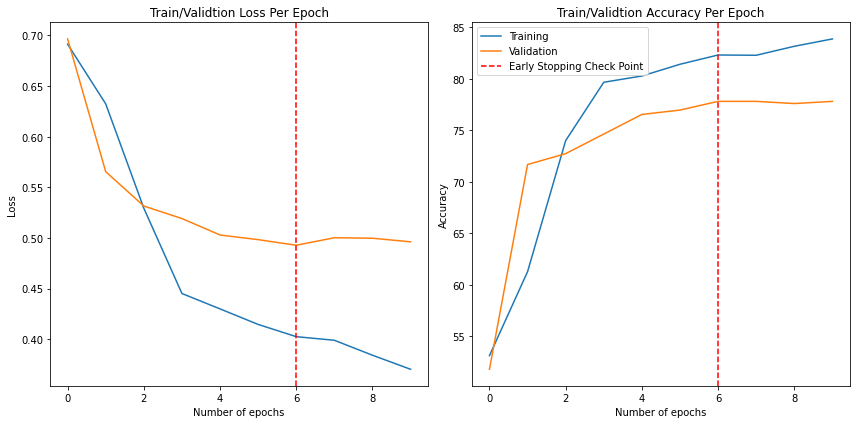


Training Session Info Stored


In [ ]:
seed_all(random_state = 60065)
bangla_transformer_cnn_tc.prepare_dataloaders(
    data_context = bangla_dc,
    train_percentage = 80)
bangla_transformer_cnn_tc.train(model = bangla_transformer_cnn)

In [ ]:
bangla_transformer_cnn_tc.test(bangla_transformer_cnn)

Test Accuracy: 78.18 %


# Apply the Hindi classifier to Bengali data (Only change: Embedding Matrix)
Here, we are using the new Bengali embedding matrix from `bangla_transformer_cnn` instead of the one trained on: Task 2 Part C, for the same reason we have trained a new embedding matrix for Hindi Transformer classifier above.

In [ ]:
hindi_trained = TransformerCNN(hindi_transformer_params)
bangla_transformer_cnn = TransformerCNN(bangla_transformer_params)

nnc.load_model(hindi_trained, "TransformerCNN/hindi_tcnn.pt")
nnc.load_model(bangla_transformer_cnn, "TransformerCNN/bangla_tcnn.pt")

bangla_from_hindi = copy.deepcopy(hindi_trained)

bangla_emb = copy.deepcopy(bangla_transformer_cnn.embedding)
print(f'Bangla Embedding: {bangla_emb}')

print(f'Embedding For bangla_from_hindi model, before replacing with bangla embedding: {bangla_from_hindi.embedding}')

bangla_from_hindi.embedding = copy.deepcopy(bangla_emb)
print(f'Embedding For bangla_from_hindi model, after replacing with bangla embedding: {bangla_from_hindi.embedding}')


Output shape after conv1: (16, 140)
Output shape after conv2: (8, 58)
Output shape after conv3: (8, 1)
Output shape after conv1: (16, 140)
Output shape after conv2: (8, 58)
Output shape after conv3: (8, 1)
Bangla Embedding: Embedding(14583, 300, padding_idx=0)
Embedding For bangla_from_hindi model, before replacing with bangla embedding: Embedding(18171, 300, padding_idx=0)
Embedding For bangla_from_hindi model, after replacing with bangla embedding: Embedding(14583, 300, padding_idx=0)



In [ ]:
bangla_from_hindi.fc1.weight[0] == hindi_trained.fc1.weight[0]

tensor([True, True, True,  ..., True, True, True])

In [ ]:
# Training Contex is independent of the model. It simply reads, preprocesses and then creates the data loader
# We can use the previous bangla training context to test transfer learning model
bangla_transformer_cnn_tc.test(bangla_from_hindi)

Test Accuracy: 58.91 %


### Sentiment Classifiers and their train, validation and test accuracy summary

| Model Description                       | Train Accuracy | Validation Accuracy | Test Accuracy |
|-----------------------------------------|----------------|---------------------|---------------|
| EncoderCNN Models                       |                |                     |               |
| Hindi                                   | 79.69 %        | 73.88 %             | 72.53 %       |
| Hindi classifier on Bengali Data        | NA             | NA                  | 50.85 %       |
| Bengali trained on top of Hindi weights | 76.30 %        | 71.40 %             | 71.03 %       |
| Bengali trained with only Bengali Data  | 75.11 %        | 67.58 %             | 68.03 %       |
| TransformerCNN Models                   |                |                     |               |
| Hindi                                   | 83.71 %        | 79.23 %             | 81.97 %       |
| Hindi classifier on Bengali Data        | NA             | NA                  | 58.91 %       |
| Bengali trained with only Bengali Data  | 81.40 %        | 76.96 %             | 78.18 %       |